# Решающие деревья

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()

In [3]:
#print(iris.DESCR)

In [4]:
iris.target[125] = 1

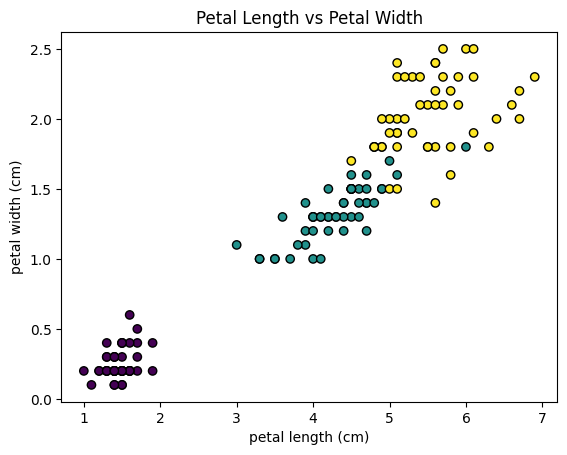

In [5]:
plt.scatter(iris.data[:, 2], iris.data[:, 3], c=iris.target, cmap='viridis', edgecolor="black")
plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])
plt.title('Petal Length vs Petal Width')
plt.show()

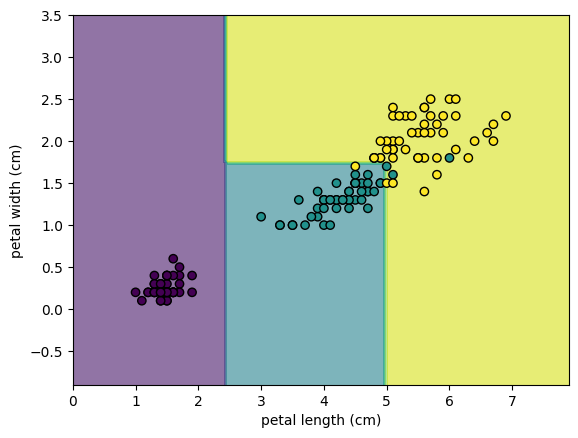

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import DecisionBoundaryDisplay
#позволяет визуализировать границы принятия решений обученной модели с указанной цветовой картой

X = iris.data[:, 2:4]

tree = DecisionTreeClassifier(max_depth=3, random_state=42).fit(X, iris.target)

fig, ax = plt.subplots()
disp = DecisionBoundaryDisplay.from_estimator(
    tree,
    X,
    response_method="predict",
    alpha=0.6,
    ax=ax,
    xlabel=iris.feature_names[2],
    ylabel=iris.feature_names[3],
    cmap=plt.cm.viridis
)

disp.ax_.scatter(iris.data[:, 2], iris.data[:, 3], c=iris.target, edgecolor="black")

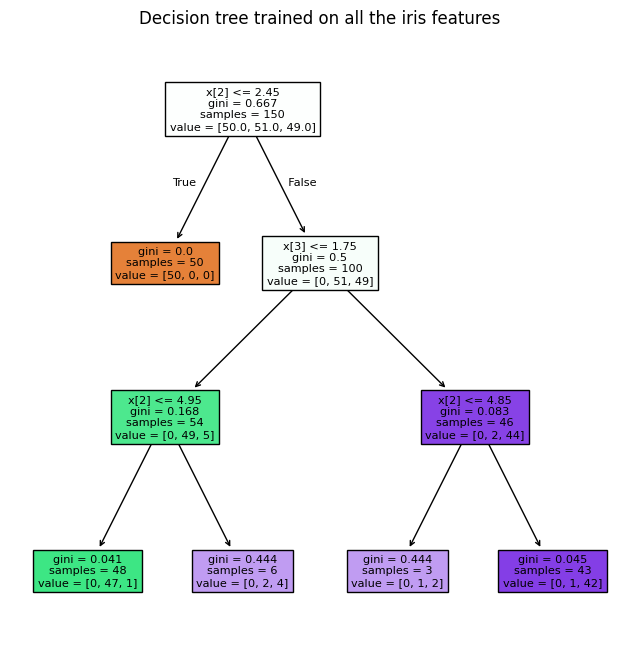

In [7]:
from sklearn.tree import plot_tree

plt.figure(figsize=(8, 8))
tree = DecisionTreeClassifier(max_depth=3, random_state=42).fit(iris.data, iris.target)
plot_tree(tree, filled=True)
plt.title("Decision tree trained on all the iris features")
plt.show()

Основная идея - сегментация пространства признаков на области с применением набора правил, который можно представить в виде дерева.

Особенности:
* Можно применять как для регрессии, так и для классификации
* Легко интерпретируются, не требуют знаний о предметной области
---
* Автоматически обрабатывают пропуски
* Работают с категориальными признаками
* Нет необходимости в нормализации
* Не чуствителен к выбросам
___
* Склонны к переобучению
* Велика доля случайности - при повторных построениях возможен разный результат



Идея построения:
1) рекурсивно выбираем признак и разбиение по нему для обучающей выборки, далее для каждой из частей продолжаем процесс.
2) pruning - отсечение решений (ветвей)

Необходимо определить:
* Метрику неоднородности ответов выборки
* Критерий остановки

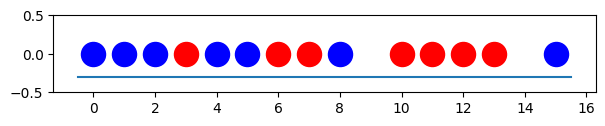

In [8]:
plt.figure(figsize=(7,1))
x1 = [3,6,7,10,11,12,13]
x2 = [0,1,2,4,5,8,15]
y = [0] * 7

plt.ylim(-0.5,0.5)
plt.plot([-0.5,15.5],[-0.3,-0.3])
plt.scatter(x1,y,s=300,color='red')
plt.scatter(x2,y,s=300,color='blue')
plt.show()

Энтропия Шеннона:

 * мат. ожидание по классам функции потерь -log(P)
 * чем определеннее система, тем меньше энтропия

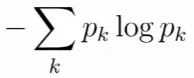

Индекс Джини:

* из экономики - оценка неравенства населения по доходам
* из комбинаторики - вероятность не вытащить из корзины с шарами дважды шар одинакового цвета


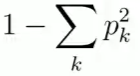

Итоговый алгоритм для узла дерева:
* Начинаем с корня и разбиения всего множества
* Для каждого возможного разбиения каждого признака считается прирост информации
* Выбирается разбиение с макс. приростом
* Если прирост меньше порога - остановка
* Иначе создание 2 дочерних узлов по разбиению, повтор алгоритма для каждого узла




Модификации:
* По типу деления (на основе комбинаций, категориальные, сферические)
* По разбиению (бинарное - множественное)

Регуляризация:
* ограничение на макс. глубину
* ограничение на количество рассматриваемых признаков в каждом узле (случайный выбор нескольких)
* ограничение на количество примеров в конечном узле
* ограничение на количество примеров в разделяемом узле
* стрижка дерева (pruning). При таком подходе дерево сначала строится до максимальной глубины, потом постепенно, снизу вверх, некоторые вершины дерева убираются за счет сравнения по качеству дерева с данным разбиением и без него

## Оценка классификации

In [9]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size = 0.5, random_state = 0)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9466666666666667

In [10]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       0.94      0.94      0.94        31
           2       0.91      0.91      0.91        23

    accuracy                           0.95        75
   macro avg       0.95      0.95      0.95        75
weighted avg       0.95      0.95      0.95        75



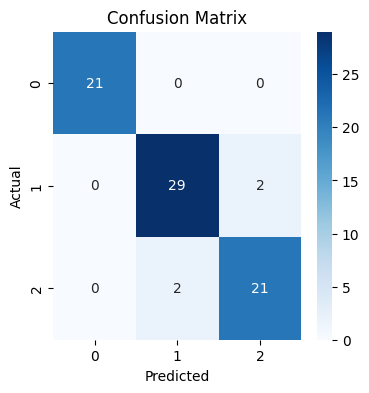

In [11]:
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

2 подхода:

One-vs-Rest (OvR) подход

Задача декомпозируется на k бинарных задач. Для каждого класса вычисляется AUC. Итоговое значение получается путем усреднения. Подход предполагает независимость классов друг от друга.

One-vs-One (OvO) подход

Считается для каждой пары классов, игнорируя все остальные (всего k(k-1)/2).
Вычислительно затратен при большом количестве классов.

Микро-усреднение:
* Сначала агрегируются предсказания и метки по всем классам, а затем вычисляется общая метрика
* Подходит при сбалансированных классах

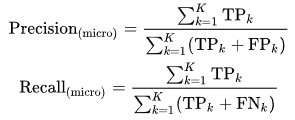

Макро-усреднение:
* Сначала вычисляются отдельные метрики для каждого класса, а затем они усредняются с равными весами
* Используется при дисбалансе классов, когда важен каждый класс

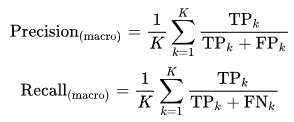

Взвешенное усреднение - важность каждого класса учитывается с присвоением им весов (например, доля примеров этого класса в обучающей выборке).

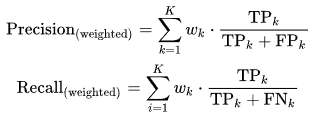

In [12]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

# Получение вероятностей для тестовых примеров
y_score = clf.predict_proba(X_test)

# Расчет ROC AUC с разными стратегиями
roc_auc_macro = roc_auc_score(y_test, y_score, average='macro', multi_class='ovr')
roc_auc_micro = roc_auc_score(y_test, y_score, average='micro', multi_class='ovr')
roc_auc_weighted = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')
roc_auc_ovo = roc_auc_score(y_test, y_score, multi_class='ovo')

print(f"Macro-averaged ROC AUC: {roc_auc_macro:.4f}")
print(f"Micro-averaged ROC AUC: {roc_auc_micro:.4f}")
print(f"Weighted ROC AUC: {roc_auc_weighted:.4f}")
print(f"One-vs-One ROC AUC: {roc_auc_ovo:.4f}")

Macro-averaged ROC AUC: 0.9608
Micro-averaged ROC AUC: 0.9600
Weighted ROC AUC: 0.9580
One-vs-One ROC AUC: 0.9621


# Регрессия

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor

In [14]:
df = pd.read_csv('train.csv', sep=',')
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [15]:
X = df[['OverallQual', 'GrLivArea', 'GarageCars',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd',
       'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces',
       'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF',
       'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr',
       'ScreenPorch', 'PoolArea', 'MoSold', '3SsnPorch', 'BsmtFinSF2',
       'BsmtHalfBath', 'MiscVal',  'LowQualFinSF', 'YrSold',
       'OverallCond', 'MSSubClass', 'EnclosedPorch', 'KitchenAbvGr']]

In [16]:
X.isnull().sum().sort_values(ascending=False)[:4]

,0
LotFrontage,259
GarageYrBlt,81
MasVnrArea,8
OverallQual,0


In [23]:
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

clf = DecisionTreeRegressor(criterion='squared_error', random_state=0) #42
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('RMSE = ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE =  43633.1075329603


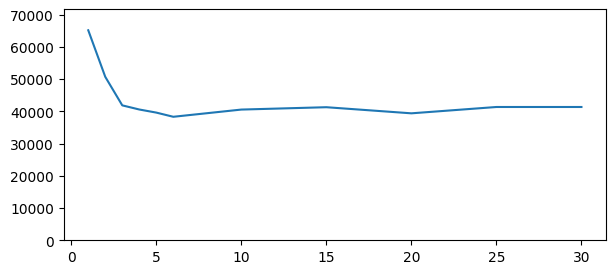

In [26]:
y = [1, 2, 3, 4, 5, 6, 10, 15, 20, 25, 30]
x = []
for depth in y:
    dt = DecisionTreeRegressor(max_depth=depth, criterion='squared_error', random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    x.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

plt.figure(figsize=(7,3))
plt.ylim(0,max(x)*1.1)
plt.plot(y,x)
plt.show()

In [29]:
dt = DecisionTreeRegressor(max_depth=2, criterion='squared_error', random_state=0)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

set(y_pred)

{np.float64(142077.6432506887),
 np.float64(206157.82558139536),
 np.float64(275040.27407407406),
 np.float64(376657.0612244898)}

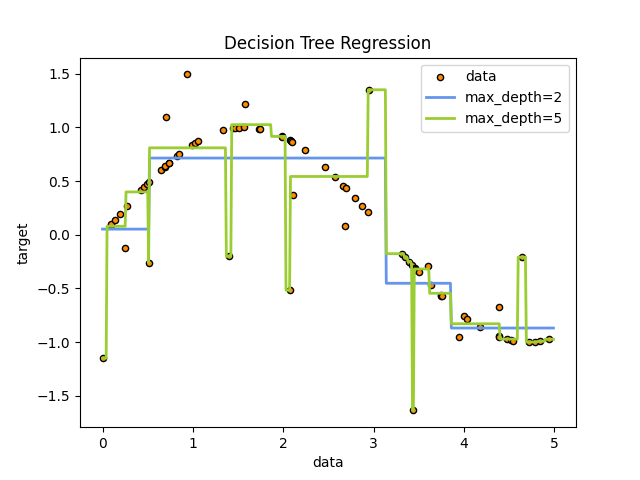